In [ ]:
# Подгружаем данные в ~/Desktop, чтобы не менять ссылку в коде
!cd ~/Desktop
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IpNZQfchwcGRGZdhbXU4ynpD9py5TDrh' -O data.csv

In [62]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, \
GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.svm import SVR
from scipy.sparse import hstack
from tqdm import tqdm

from catboost import CatBoostRegressor, Pool, cv, FeaturesData

%matplotlib inline

In [7]:
# собираем DataFrame из скачанных данных (берем последний json, так как в нем максимальное количество собранной
# информации)
# собирается долго - около 2 часов
# после первой сборки - этот блок не нужен

# data = pd.DataFrame()
# files = os.listdir('../../../Desktop/data/')
# with open('../../../Desktop/data/' + files[-1], 'r') as f:
#     new_dict = {}
#     new_dict = json.loads(f.read(), encoding='mac_cyrillic')
#     df = pd.DataFrame()
#     i = 0
#     for key, val in tqdm(new_dict.items()):
#         df.loc[i,'link'] = key
#         for k, v in val.items():
#             df.loc[i,k] = v
#         i += 1
#     data = pd.concat([data, df])

In [8]:
# сохраняем собранный датасет на диск - чтобы каждый раз не собирать по 2 часа 
# data.to_csv('~/Desktop/data.csv')

In [15]:
# считываем данные, сохраненные на прошлом шаге (так как уже все собрано - начинаем сразу отсюда)
data = pd.read_csv('~/Desktop/data.csv', index_col=0, encoding='utf-8')

### Предобработка данных

In [50]:
# обрабатываем столбцы датасета. Если данных нет - возвращаем None

# переводим год в числовой формат (везде float для catboost FeaturesData)
def to_int_year(year_row):
    return float(year_row)

# переводим километраж в числовой формат
def to_int_km(kmAge_row):
    if not kmAge_row:
        return None
    regex = re.compile('\d+')
    cleaned_row = ''.join(regex.findall(kmAge_row))
    return float(cleaned_row)

# разбиваем на 3 колонки информацию по двигателю (объем, мощность в л.с. и тип топлива)
def split_engine_col(engine_row):
    volume = None
    horse_power = None
    fuel_type = None
    if engine_row == None:
        return volume, horse_power, fuel_type
    
    params = engine_row.split('/')
    params_num = len(params)
    for p in params:
        if ('бензин' in p.lower()) or ('дизел' in p.lower()) or ('газ' in p.lower()):
            fuel_type = p
        if 'л.' in p.lower():
            regex = re.compile('\d+')
            horse_power = float(''.join(regex.findall(p)))
        if ' л' in p:
            regex = re.compile('\d+\.\d+')
            volume = float(''.join(regex.findall(p)))
    return [volume, horse_power, fuel_type]

# вытаскиваем числа из фразы про стоимость налога (данное поле плохо посчитано у авто.ру и много,
# пропусков - его в итоге убрали)
def to_int_transptax(transptax_row):
    if not transptax_row:
        return transptax_row
    regex = re.compile('\d+')
    transptax = float(''.join(regex.findall(transptax_row.replace('\xa0', ' '))))
    return transptax

# достаем число владельцев
def fix_ownersCount(ownersCount_row):
    owners_list = ['3 или более', '2 владельца', '1 владелец']
    if not ownersCount_row:
        return None
    if ownersCount_row.replace('\xa0', ' ') not in owners_list:
        ownersCount_row = '3 или более'
    return float(ownersCount_row[0])

# оставляем информативный кусок pts - поле далее убрано, ухудшает метрики данных
def fix_pts(pts_row):
    pts_list = ['Оригинал', 'Дубликат', None]
    if pts_row not in pts_list:
        return 'Оригинал'
    return pts_row

# оставляем информативный кусок vin - поле далее убрано, ухудшает метрики данных
def fix_vin(vin_row):
    if not vin_row:
        return None
    return vin_row.replace('*', '')

# считаем время владения автомобилем в днях
def calculate_owningTime(owningTime_row):
    if not owningTime_row:
        return None
    regex = re.compile('\d+ [мес]*[лет]*[год]*')
    periods = regex.findall(owningTime_row)
    regex_num = re.compile('\d+')
    if len(periods) == 2:
        years = int(regex_num.search(periods[0])[0])*365.5
        month = int(regex_num.search(periods[1])[0])*30.5
        return years + month
    elif (len(periods) == 1) and ('мес' in periods[0]):
        years = 0
        month = int(regex_num.search(periods[0])[0])*30.5
        return month
    elif (len(periods) == 1) and (('год' in periods[0]) or ('лет' in periods[0])): 
        years = int(regex_num.search(periods[0])[0])*365.5
        month = 0
        return years + month

# убираем мусор из информации о таможне - поле далее убрано, ухудшает метрики данных
def fix_customs(customs_row):
    customs_list = ['Растаможен', 'Не растаможен', None]
    if customs_row not in customs_list:
        return 'Растаможен'
    return customs_row

# достаем номер региона рег номера - поле далее убрано, ухудшает метрики данных
def fix_license_plate(licensePlate_row):
    if not licensePlate_row:
        return None
    return licensePlate_row.split('|')[1]

# общая функция для очистки данных от неправильного кодирования
def fix_bad_encoding(row):
    if not row:
        return None
    if 'Ð' in row:
        return None
    return row

# очищаем цену от байтовых разделителей (где-то нужно было с кодировкой поработать, но - поезд ушел :) )
def fix_price(price_row):
    try:
        return float(price_row[:-1].replace('\xa0', ''))
    except:
        return None

# переводим дату публикации в формат unix-timestamp
def calculate_publ_date(publication_date):
    month_dict = {
        'января' : '01',
        'февраля' : '02',
        'марта' : '03',
        'апреля' : '04',
        'мая' : '05',
        'июня' : '06',
        'июля' : '07',
        'августа' : '08',
        'сентября' : '09',
        'октября' : '10',
        'ноября' : '11',
        'декабря' : '12',
    }
    
    i = 1
    for key in month_dict:
        if key in publication_date:
            break
        i += 1
        if i > 12:
            return None
    regex = re.compile('\d{4}')
    year_match = regex.search(publication_date)
    if not year_match:
        year = ' 2020'
        publication_date = publication_date + year
    
    for key in month_dict:
        if key in publication_date:
            pub_date = publication_date.replace(key, month_dict[key])    
    date = datetime.strptime(pub_date, '%d %m %Y').timestamp()
    return date

# достаем инфо о количестве просмотров
def fix_views(views_row):
    if not views_row:
        return None
    return float(views_row.split()[0])

# достаем название бренда, модели и модификации из поля model_name
def split_brand_model(model_row):
    fix_list = [
    '«Чайка»',
    '«Волга»',
    'Siber',
    '«Победа»',
    'Defender',
    'Discovery',
    'Freelander',
    'Range Rover',
    'Granta',
    'Kalina',
    'Largus',
    'Priora',
    'Vesta',
    'Vitara',
    'Picasso',
    'Cherokee',
    'Series',
    'WRX',
    'Lancaster',
    '(ВАЗ)',
    ]
    brand, model, modif = model_row.split()[0].strip(), model_row.split()[1].strip(), ' '.join(model_row.split()[2:])
    if brand == 'Land':
        brand += ' Rover'
        model = model.replace('Rover', '').strip()
    
    modif = modif.strip()
    for part in fix_list:
        if part in modif:
            modif = modif.replace(part, '').strip()
            model = (model + ' ' + part).strip()
    return [brand, model, modif]

# функция, суммирующая все предыдущие
def clear_data(data_df):
    data_new = pd.DataFrame()
    data_new['year'] = data_df['year'].apply(to_int_year)
    data_new['kmAge'] = data_df['kmAge'].apply(to_int_km)
    data_new['bodytype'] = data_df['bodytype'].apply(fix_bad_encoding)
    data_new['color'] = data_df['color'].apply(fix_bad_encoding)
    
    # делаем сразу 3 поля
    engine_data = pd.DataFrame(data_df['engine'].apply(split_engine_col).tolist(), 
                               columns=['engine_vol','engine_hp','engine_fuel'],
                               index=data_df.index)
    data_new = pd.concat([data_new, engine_data], axis=1)
    
    data_new['transmission'] = data_df['transmission'].apply(fix_bad_encoding)
    data_new['wheel'] = data_df['wheel'].apply(fix_bad_encoding)
    data_new['state'] = data_df['state'].apply(fix_bad_encoding)
    data_new['ownersCount'] = data_df['ownersCount'].apply(fix_ownersCount)
    data_new['pts'] = data_df['pts'].apply(fix_pts)
    data_new['owningTime'] = data_df['owningTime'].apply(calculate_owningTime)
    data_new['customs'] = data_df['customs'].apply(fix_customs)
    data_new['vin'] = data_df['vin'].apply(fix_vin)
    data_new['licensePlate'] = data_df['licensePlate'].apply(fix_license_plate)
    data_new['model_name'] = data_df['model_name'].apply(fix_bad_encoding)
    data_new['price'] = data_df['price'].apply(fix_price)
    data_new['publication_date'] = data_df['publication_date'].apply(calculate_publ_date)
    data_new['photo_count'] = data_df['photo_count']
    not_na_cols = ['year', 'kmAge', 'model_name', 'price']
    
    # делаем сразу 3 поля
    brand_model = pd.DataFrame(data_df['model_name'].apply(split_brand_model).tolist(), 
                               columns=['brand','model','modification'],
                               index=data_df.index)
    data_new = pd.concat([data_new, brand_model], axis=1)
    data_new['km_per_year'] = data_new['kmAge']/(2020.1 - data_new['year'])
    data_new['km_per_owner'] = data_new['kmAge']/data_new['ownersCount']
    data_new['publ_since'] = datetime.timestamp(datetime.now()) - data_new['publication_date']
    data_new[['engine_vol', 'engine_hp']].fillna(data_new[['engine_vol', 'engine_hp']].mean(), inplace=True)
    data_new['hp_per_vol'] = data_new['engine_hp']/data_new['engine_vol']
 
    data_new.dropna(subset=not_na_cols, inplace=True)
    return data_new

In [51]:
# удаляем строки, где нет ключевых данных
data_no_na = data.dropna(subset=['year', 'price', 'model_name', 'kmAge', 'engine'])

# убираем неудобный для if/else 'nan', меняем его на False
data_no_na.fillna(False, inplace=True)

# очищенный датасет
final_data = clear_data(data_no_na)

/Users/maksim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/Users/maksim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [52]:
# числовые и категориальные столбцы
numeric_features = ['year', 'kmAge', 'ownersCount', 'km_per_year', 'km_per_owner',
                    'photo_count', 'engine_vol', 'engine_hp', 'publication_date']
cat_features =[
    'model_name',
    'bodytype',
    'color',
    'transmission',
    'brand',
    'model',
    'modification',
    'engine_fuel'
]

# выделяем признаки
X = final_data.drop(['price'], axis=1)

# считаем средние значения и самые частотные значения для числовых и категориальных данных
numeric_features_mean = final_data[numeric_features].mean().astype('float32')
cat_features_mostfreq = final_data[cat_features].mode(0).iloc[0]

# заполняем пустоты средними значениями для числовых данных
# заполняем пустоты наиболее частотными значениями для категориальных данных
X[numeric_features] = X[numeric_features].fillna(numeric_features_mean).astype('float32')
X[cat_features] = X[cat_features].fillna(cat_features_mostfreq)

# выделяем target
y = final_data.price

In [53]:
# ручная чистка от выбросов - решения sklern типа DBScan, Isolated tree и др не дали хороших результатов

# находим индексы раритетных авто
year_outliers_indx = list(X.year[X.year < 1980.0].index)

# находим индексы выбросов с очень большим пробегом
kmAge_peaks_indx = list(X.kmAge[X.kmAge > 8e5].index)

# убираем редкие нецелевые виды кузова
bodytype_names = X.bodytype.value_counts().iloc[12:].index
bodytype_outliers = ['тент', 'промтоварный автофургон', 'изотермический фургон',
       'рефрижератор', 'бортовой грузовик',
       'купе-хардтоп', 'внедорожник открытый', 'эвакуатор',
       'фургон для торговли', 'скорая помощь',
       'кэмпер', 'микровэн', 'тарга', 'седан-хардтоп',
       'шасси', 'самосвал', 'лимузин', 'цистерна',
       'самосвал с 2-х разгрузкой']
bodytype_outliers_index = list(X[X.bodytype.isin(bodytype_outliers)].index)

# находим индексы выбросов по объему двигателя
engine_hp_outliers_indx = list(X.engine_hp[(X.engine_hp < 50) | (X.engine_hp > 1500)].index)

# находим индексы очень редких видов топлива
engine_fuel_outliers = list(X.engine_fuel.value_counts().iloc[4:].index)
engine_fuel_outliers_index = list(X[X.engine_fuel.isin(engine_fuel_outliers)].index)

# находим индексы ошибочных объемов
engine_vol_outliers_indx = list(X.engine_vol[(X.engine_vol > 7.0) | (X.engine_vol < 0.5)].index)

# находим устаревший редкий термин трансмиссии - видимо старая категория на авто.ру
transmission_outliers_indx = list(X.transmission[X.transmission == 'робот'].index)

# видимо среднее значение по ownersCount - почему-то убрал....
owners_count_outliers_index = list(X.ownersCount[X.ownersCount == 2.1904449462890625].index)

# ошибочная цена в 68 000 000 за какой-то Форд Куга...
price_outliers_index = list(y[(y>3e7)].index)# | (y<1e5)].index)

# публикации, которые были сделаны до 2016 года - тоже убираем
pub_date_outliers_index = list(X[X.publication_date < 1451595600.0].index)

# суммируем все индексы
outliers_indx = list(set(year_outliers_indx + kmAge_peaks_indx + bodytype_outliers_index +
                         engine_hp_outliers_indx + engine_fuel_outliers_index + engine_vol_outliers_indx + 
                         transmission_outliers_indx + owners_count_outliers_index + price_outliers_index +
                         pub_date_outliers_index
))

# итогам первых прогонов - поля ниже - портят данные, без них метрики лучше
# вычищаем все данные с индексами = outlier index
X_cleaned = X.drop(['wheel', 'customs', 'vin','owningTime', 
                    'state'], axis=1).drop(outliers_indx)

# вычищаем все данные с индексами = outlier index
# логарифмируем target
y_cleaned = final_data.price.drop(outliers_indx).apply(np.log)

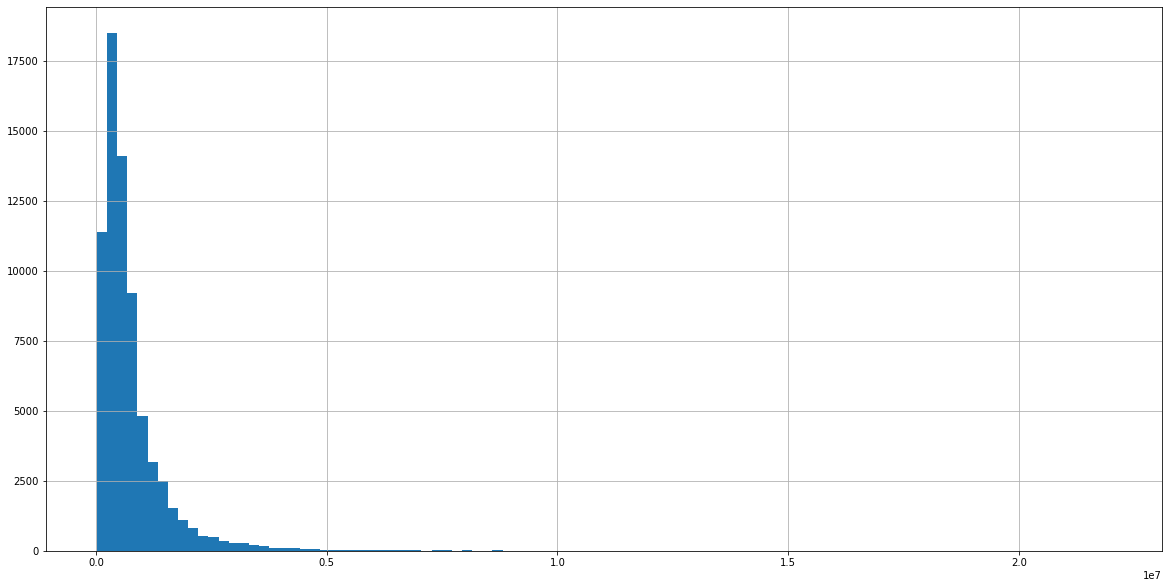

In [57]:
# target после логарифмирования - купол и совсем другие данные по MAPE
fig, ax = plt.subplots(figsize=(20, 10))
final_data.price.drop(outliers_indx).hist(bins=100);

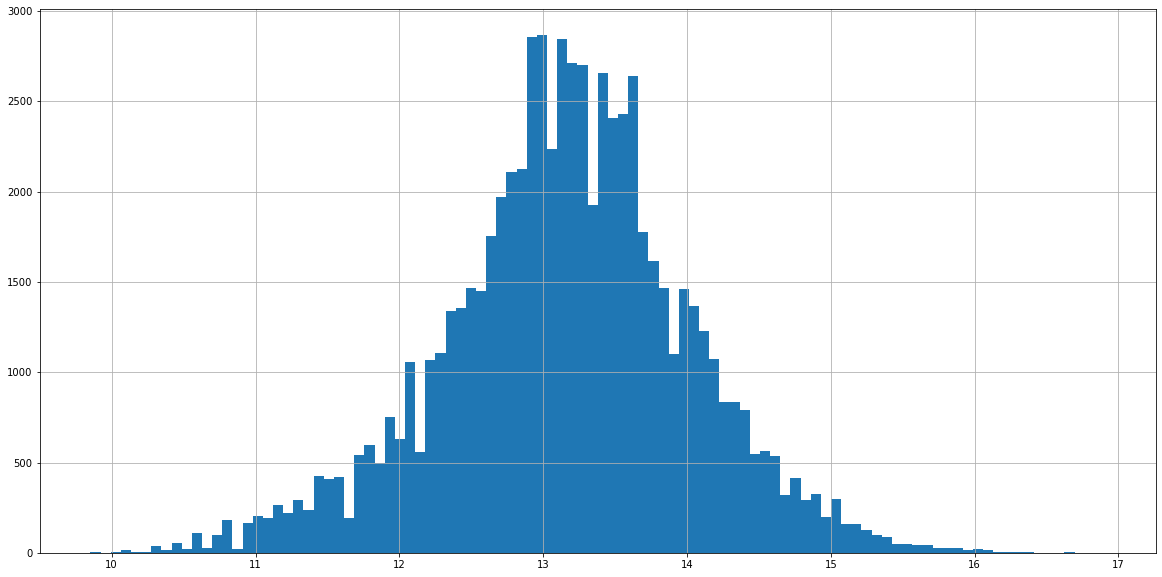

In [61]:
fig, ax = plt.subplots(figsize=(20, 10))
y_cleaned.hist(bins=100);

In [37]:
# для обучения брал выборки в 5-10%
X_cleaned_sample = X_cleaned.sample(frac=1.0, random_state=42)
y_cleaned_sample = y_cleaned.sample(frac=1.0, random_state=42)

scaler = StandardScaler()
encoder = OneHotEncoder()

# PolyFeatures не помогают, как показала практика
# poly = PolynomialFeatures()
# X_poly = poly.fit_transform(X_cleaned_sample[numeric_features])

# скелим числовые данные
X_num = scaler.fit_transform(X_cleaned_sample[numeric_features])
# делаем OHE для категориальных данных
X_cat = encoder.fit_transform(X_cleaned_sample[cat_features])

# стыкуем все
X = hstack((X_num, X_cat))

### Моделирование

In [38]:
# хотел сделать через cross_val - но target нужно вытаскивать из логарифма, поэтому scoring получается кастомный
# как сделать cross_val на кастомном scoring - пока не умею
# поэтому делаем православный train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_cleaned_sample, 
                                                    test_size=0.3, shuffle=True, random_state=42)

In [39]:
# гиперпараметры подобраны множеством попыток
cb = CatBoostRegressor(depth=7, iterations=10000, learning_rate=0.045, verbose=False)

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)

# считаем наш кастомный mape, восстанавливая target из логарифма
mape = (abs(np.exp(y_pred) - np.exp(y_test))/np.exp(y_test)).mean()


# то же можно сделать с помощью FeaturesData/Pool - с моим неумением тюнить CatBoost разницы не увидел

# X_cleaned_sample = X_cleaned.sample(frac=0.99, random_state=42)
# y_cleaned_sample = y_cleaned.sample(frac=0.99, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_cleaned_sample, y_cleaned_sample, test_size=0.3, shuffle=True)

# X_train_fd = FeaturesData(num_feature_data=X_train[numeric_features].values, 
#                           cat_feature_data=X_train[cat_features].values,
#                           num_feature_names=numeric_features,
#                           cat_feature_names=cat_features)
# X_test_fd = FeaturesData(num_feature_data=X_test[numeric_features].values, 
#                          cat_feature_data=X_test[cat_features].values,
#                          num_feature_names=numeric_features,
#                          cat_feature_names=cat_features)
# X_train_pool = Pool(data=X_train_fd, label=y_train)
# X_test_pool = Pool(data=X_test_fd, label=y_test)

# cb.fit(X_train_pool)
# y_pred = cb.predict(X_test_pool)
# (abs(np.exp(y_pred) - np.exp(y_test))/np.exp(y_test)).mean()

### Результат

In [40]:
print(f'MAPE = {mape}')

MAPE = 0.12656742777779523


### ДОПОЛНЕНИЯ

In [ ]:
# Можно запустить Catboost через Pool - в целом тот же результат
# Сделал проверку MAPE xthtp

In [ ]:
X_cleaned_sample = X_cleaned.sample(frac=0.99, random_state=42)
y_cleaned_sample = y_cleaned.sample(frac=0.99, random_state=42)

X_cleaned_fd = FeaturesData(num_feature_data=X_cleaned_sample[numeric_features].values, 
                    cat_feature_data = X_cleaned_sample[cat_features].values,
                    num_feature_names = numeric_features,
                    cat_feature_names = cat_features)


data_pool = Pool(data=X_cleaned_fd, label=y_cleaned_sample)
reg = CatBoostRegressor()

# Опять же - можено нельзя поставить кастомный scoring (или можно - но не знаю как)
params = {"iterations": 10000,
          "depth": 7,
          "learning_rate": 0.045,
          "loss_function": "MAE",
          "verbose": False}

In [ ]:
scores = cv(data_pool,
            params,
            fold_count=3, 
            plot="True")

In [ ]:
# проверка других моделей на кроссвалидации на встроенном MAE (который ввиду логарифмироания не имеет никакого
# физического смысла, но уменьшать его можно)

In [ ]:
# оооочень долго учится лес. Невыносимо, часа 4-5 на 10 000 деревьев
regressor = RandomForestRegressor(random_state=42)
params = {
    'n_estimators' : [5000],# 10000],
    'max_depth' : [30],
    'criterion' : ['mse']
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# почему-то учится еще дольше, чем лес
regressor = ExtraTreesRegressor(random_state=42)
params = {
    'n_estimators' : [300, 1000],# 5000],
    'max_depth' : [100],
    'criterion' : ['mae']
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# на удивления помогли деревья нестандартной глубины (глубина 7 работает лучше чем дефолтная 3) и нужно
# много деревьев - 10 000 - лучший cross-val
regressor = CatBoostRegressor()
params = {'depth':[3, 6, 7, 8],
          'iterations':[10000, 15000, 20000],
          'learning_rate':[0.05, 0.07, 0.1]}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# долго и результат хуже, чем у Catboost

regressor = GradientBoostingRegressor(random_state=42)
params = {
    'n_estimators' : [2000],
    'max_depth' : [3],
    'learning_rate' : [0.1, 0.2]
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# Результат как у регрессий, но на больших данных SVR закончит вычисления "никогда" на моем ноутбуке

regressor = SVR()
params = {
    'C': [0.25],
    'kernel': ['linear'],
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# очень быстро, но результат хуже, чем у CatBoost - 0.155 против 0.125

regressor = Lasso()
params = {
    'alpha': [7e-5]
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# результат чуть хуже, чем у Lasso

regressor = Ridge()
params = {
    'alpha': [1.5]
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# Слабее Lasso, Ridge

regressor = LinearRegression()
params = {
    'fit_intercept': [True, False]
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# записал рзультаты эстиматоров на кросс-валидации по MAE по логарифмированному target

In [ ]:
""""
Random Forest
{'criterion': 'mse', 'max_depth': 30, 'n_estimators': 5000}
MAE = 0.18613126948166414

Extra Trees
{'criterion': 'mae', 'max_depth': 100, 'n_estimators': 50}
MAE = 0.17843565781992193

Linear Regression
{'fit_intercept': True}
MAE = 0.16166042820598073

Ridge
{'alpha': 2}
MAE = 0.1549745451687659

Lasso
{'alpha': 7e-05}
MAE = 0.15383390684128465

SVR
{'C': 0.25, 'kernel': 'linear'}
MAE = 0.15392866099694105

GradientBoost
{'max_depth': 5, 'n_estimators': 500}
MAE = 0.1667841712619347

In [ ]:
# пробовал стекинг - результат хуже, чем у отдельных моделей. 

In [ ]:
regressors = [
    ('Ridge', Ridge(alpha=1.5)),
    ('Lasso', Lasso(alpha=2)),
    ('Linear', LinearRegression())
]
final_estimator = CatBoostRegressor(depth=7, iterations=10000, learning_rate=0.1)
# final_estimator = RandomForestRegressor(max_depth=30, n_estimators=5000)
# final_estimator = GradientBoostingRegressor(max_depth=7, n_estimators=2000)

In [ ]:
stack_regr = StackingRegressor(estimators=regressors, final_estimator=final_estimator, 
                                             cv=5, n_jobs=-1)
mae = cross_val_score(estimator=stack_regr, X=X, y=y_cleaned_sample, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)